In [1]:
import h5py
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Subset, Dataset, DataLoader
from transformers import BertTokenizer, BertModel, ViTModel, ViTImageProcessor

2025-11-12 07:21:14.948785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762932074.971218     157 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762932074.978063     157 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# =============================================================================
# Dataset
# =============================================================================
class FashionGenDataset(Dataset):
    def __init__(self, h5_path):
        self.h5 = h5py.File(h5_path, 'r')
        self.texts = self.h5['input_description']
        self.imgs = self.h5['input_image']
        self.fe = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        caption = self.texts[idx][0].decode('utf-8', errors='ignore')
        raw_img = Image.fromarray(self.imgs[idx])
        cropped_img = self.crop_and_resize_img(raw_img)
        pixel_values = self.fe(images=cropped_img, return_tensors="pt")['pixel_values'].squeeze(0)
        return caption, pixel_values, idx

    @staticmethod
    def crop_and_resize_img(img, threshold=245):
        img_np = np.array(img)
        non_white_mask = np.any(img_np < threshold, axis=2)
        if not np.any(non_white_mask):
            return img.resize((224, 224))
        coords = np.argwhere(non_white_mask)
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1
        cropped_img = img.crop((x0, y0, x1, y1))
        resized_img = cropped_img.resize((224, 224))
        return resized_img

In [3]:
# =============================================================================
# Encoders
# =============================================================================
class TextEncoder(nn.Module):
    def __init__(self, concept_terms, proj_dim=500, sim_threshold=0.7, freeze_bert=False):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.proj = nn.Linear(768, proj_dim)
        self.threshold = sim_threshold
        self.concept_terms = concept_terms
        self.freeze_bert = freeze_bert

        with torch.no_grad():
            concept_tokens = self.tokenizer(concept_terms, return_tensors="pt", padding=True, truncation=True)
            concepts_output = self.bert(**concept_tokens).last_hidden_state
            concepts_mask = concept_tokens["attention_mask"].unsqueeze(-1)
            concepts_avg = (concepts_output * concepts_mask).sum(dim=1) / concepts_mask.sum(dim=1)
        self.register_buffer("concept_raw_embeds", concepts_avg)

    def forward(self, texts):
        device = next(self.parameters()).device
        tokens = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
        attn_mask = tokens["attention_mask"].unsqueeze(-1)

        if self.freeze_bert:
            with torch.no_grad():
                output = self.bert(**tokens).last_hidden_state
        else:
            output = self.bert(**tokens).last_hidden_state

        output_norm = F.normalize(output, dim=-1)
        concept_norm = F.normalize(self.concept_raw_embeds, dim=-1)
        sim = torch.matmul(output_norm, concept_norm.T)

        enriched = []
        for b in range(sim.size(0)):
            enriched_words = []
            for l in range(sim.size(1)):
                if attn_mask[b, l] == 0:
                    continue
                sims = sim[b, l]
                valid_mask = sims >= self.threshold
                if valid_mask.any():
                    max_idx = sims[valid_mask].argmax()
                    concept_idx = valid_mask.nonzero(as_tuple=False)[max_idx]
                    best_concept = self.concept_raw_embeds[concept_idx]
                    enriched_word = (output[b, l] + best_concept) / 2
                else:
                    enriched_word = output[b, l]
                enriched_words.append(enriched_word)
            enriched_sentence = torch.stack(enriched_words).mean(dim=0)
            enriched.append(enriched_sentence)

        enriched = torch.stack(enriched)
        return self.proj(enriched)


class ImageEncoder(nn.Module):
    def __init__(self, proj_dim=500, topk=8):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224', output_attentions=True)
        self.proj = nn.Linear(768, proj_dim)
        self.topk = topk

    def forward(self, pixel_values):
        vit_out = self.vit(pixel_values=pixel_values)
        out = vit_out.last_hidden_state
        attn = vit_out.attentions[-1]
        patches = out[:, 1:]
        scores = attn[:, :, 0, 1:].mean(dim=1)
        k = min(self.topk, patches.size(1))
        idx = scores.topk(k, dim=1).indices
        selected = patches.gather(1, idx.unsqueeze(-1).expand(-1, -1, patches.size(2)))
        avg = selected.mean(dim=1)
        return self.proj(avg)

In [4]:
# =============================================================================
# SPF Module
# =============================================================================
class SemanticProgressiveFusionModule(nn.Module):
    def __init__(self, hidden_dim=500, num_prototypes=16, tau1=0.07, tau2=0.1, 
                 eta=1.0, gamma1=0.5, beta1=0.5):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_prototypes = num_prototypes
        
        self.tau1 = nn.Parameter(torch.tensor(tau1))
        self.tau2 = nn.Parameter(torch.tensor(tau2))
        self.eta = nn.Parameter(torch.tensor(eta))
        self.gamma1 = nn.Parameter(torch.tensor(gamma1))
        self.beta1 = nn.Parameter(torch.tensor(beta1))
        
        self.W_text_1 = nn.Linear(hidden_dim, hidden_dim)
        self.W_image_1 = nn.Linear(hidden_dim, hidden_dim)
        
        self.prototypes = nn.Parameter(torch.randn(num_prototypes, hidden_dim))
        nn.init.xavier_uniform_(self.prototypes)
        
        self.W_image_2 = nn.Linear(hidden_dim, hidden_dim)
        self.W_text_2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.text_out_proj = nn.Linear(hidden_dim, hidden_dim)
        self.image_out_proj = nn.Linear(hidden_dim, hidden_dim)
        
        self.norm_text = nn.LayerNorm(hidden_dim)
        self.norm_image = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.1)
        
    def compute_entropy(self, attention_weights):
        eps = 1e-8
        attention_weights = attention_weights.clamp(min=eps)
        entropy = -torch.sum(attention_weights * torch.log(attention_weights + eps), dim=-1)
        return entropy
    
    def stage1_fine_grained_alignment(self, X_text, X_image):
        text_proj = self.W_text_1(X_text)
        image_proj = self.W_image_1(X_image)
        
        S_1 = torch.tanh(torch.matmul(text_proj.unsqueeze(1), image_proj.unsqueeze(2)).squeeze())
        A_1 = F.softmax(S_1 / self.tau1, dim=0)
        X_text_1 = X_text + self.gamma1 * A_1.unsqueeze(-1) * X_image
        entropy_1 = self.compute_entropy(A_1.unsqueeze(-1))
        
        return X_text_1, entropy_1, A_1
    
    def stage2_part_level_prototypes(self, X_text_1, X_image, A_1):
        P_2_norm = F.normalize(self.prototypes, dim=-1)
        image_proj = self.W_image_2(X_image)
        image_proj_norm = F.normalize(image_proj, dim=-1)
        
        proto_sim = torch.matmul(image_proj_norm, P_2_norm.t())
        R_2 = F.softmax(proto_sim / self.tau2, dim=-1)
        U_2 = torch.matmul(R_2, self.prototypes)
        
        text_proj = self.W_text_2(X_text_1)
        part_affinity = torch.matmul(text_proj.unsqueeze(1), U_2.unsqueeze(2)).squeeze()
        
        A_2 = torch.sigmoid(part_affinity) + self.beta1 * A_1
        X_text_2 = A_2.unsqueeze(-1) * U_2
        entropy_2 = self.compute_entropy(R_2)
        
        return X_text_2, X_image, entropy_2, R_2
    
    def stage3_entropy_regulated_fusion(self, X_text, X_image, 
                                       X_text_1, entropy_1,
                                       X_text_2, X_image_2, entropy_2):
        entropy_0 = torch.zeros_like(entropy_1)
        
        conf_0 = torch.exp(-entropy_0 / self.eta)
        conf_1 = torch.exp(-entropy_1 / self.eta)
        conf_2 = torch.exp(-entropy_2 / self.eta)
        
        total_conf = conf_0 + conf_1 + conf_2 + 1e-8
        
        omega_0 = conf_0 / total_conf
        omega_1 = conf_1 / total_conf
        omega_2 = conf_2 / total_conf
        
        X_text_fused = (omega_0.unsqueeze(-1) * X_text + 
                        omega_1.unsqueeze(-1) * X_text_1 + 
                        omega_2.unsqueeze(-1) * X_text_2)
        
        X_image_fused = (omega_0.unsqueeze(-1) * X_image + 
                         omega_1.unsqueeze(-1) * X_image + 
                         omega_2.unsqueeze(-1) * X_image_2)
        
        X_text_final = self.text_out_proj(X_text_fused)
        X_image_final = self.image_out_proj(X_image_fused)
        
        X_text_final = self.norm_text(X_text_final)
        X_image_final = self.norm_image(X_image_final)
        
        X_text_final = self.dropout(X_text_final)
        X_image_final = self.dropout(X_image_final)
        
        stats = {
            'omega_0': omega_0.mean().item(),
            'omega_1': omega_1.mean().item(),
            'omega_2': omega_2.mean().item(),
            'entropy_1': entropy_1.mean().item(),
            'entropy_2': entropy_2.mean().item()
        }
        
        return X_text_final, X_image_final, stats
    
    def forward(self, X_text, X_image):
        X_text_1, entropy_1, A_1 = self.stage1_fine_grained_alignment(X_text, X_image)
        X_text_2, X_image_2, entropy_2, R_2 = self.stage2_part_level_prototypes(
            X_text_1, X_image, A_1
        )
        X_text_final, X_image_final, stats = self.stage3_entropy_regulated_fusion(
            X_text, X_image, X_text_1, entropy_1, X_text_2, X_image_2, entropy_2
        )
        
        return X_text_final, X_image_final, stats

In [5]:
# =============================================================================
# Evaluator
# =============================================================================
class RetrievalEvaluator:
    def __init__(self, text_encoder, image_encoder, spf_module, device, use_spf=True):
        self.text_encoder = text_encoder.eval()
        self.image_encoder = image_encoder.eval()
        self.spf_module = spf_module.eval() if spf_module is not None else None
        self.device = device
        self.use_spf = use_spf

    def extract_embeddings(self, data_loader):
        text_embeds = []
        image_embeds = []
        indices = []
        
        desc = "Extracting (with SPF)" if self.use_spf else "Extracting (baseline)"
        
        with torch.no_grad():
            for captions, images, idx in tqdm(data_loader, desc=desc):
                images = images.to(self.device)
                
                text_feats = self.text_encoder(captions)
                image_feats = self.image_encoder(images)
                
                if self.use_spf and self.spf_module is not None:
                    refined_text, refined_image, _ = self.spf_module(text_feats, image_feats)
                    text_embeds.append(refined_text.cpu())
                    image_embeds.append(refined_image.cpu())
                else:
                    text_embeds.append(text_feats.cpu())
                    image_embeds.append(image_feats.cpu())
                
                indices.extend(idx.tolist())

        return torch.cat(text_embeds, dim=0), torch.cat(image_embeds, dim=0), indices

    def compute_similarity_matrix(self, a, b):
        a_norm = F.normalize(a, dim=1)
        b_norm = F.normalize(b, dim=1)
        return torch.mm(a_norm, b_norm.T)

    def retrieval_ranks(self, sim_matrix):
        N = sim_matrix.size(0)
        ranks = []
        for i in range(N):
            order = torch.argsort(sim_matrix[i], descending=True)
            rank = (order == i).nonzero(as_tuple=True)[0].item() + 1
            ranks.append(rank)
        return ranks

In [6]:
# =============================================================================
# Metrics and Utilities
# =============================================================================
def calculate_recall_at_k(ranks, ks=(1,5,10)):
    arr = np.array(ranks)
    return {f'R@{k}': float((arr<=k).mean()) for k in ks}

def calculate_metrics(ranks):
    metrics = calculate_recall_at_k(ranks)
    metrics.update({
        'MedR': float(np.median(ranks)),
        'MeanR': float(np.mean(ranks)),
        'MRR': float(np.mean([1.0/r for r in ranks]))
    })
    return metrics

def print_results_table(results):
    header = f"{'Task':<20}{'R@1':>8}{'R@5':>8}{'R@10':>8}{'MedR':>8}{'MeanR':>8}{'MRR':>8}"
    print(header)
    print('-'*len(header))
    for task, m in results.items():
        print(f"{task:<20}{m['R@1']:>8.3f}{m['R@5']:>8.3f}{m['R@10']:>8.3f}" +
              f"{m['MedR']:>8.1f}{m['MeanR']:>8.2f}{m['MRR']:>8.3f}")

def plot_comparison_bars(baseline_results, spf_results):
    """Bar chart comparing baseline vs SPF"""
    metrics = ['R@1', 'R@5', 'R@10', 'MRR']
    baseline_vals = [baseline_results['Average'][m] for m in metrics]
    spf_vals = [spf_results['Average'][m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, baseline_vals, width, label='Baseline (Module 1+2)', 
                   color='#e74c3c', alpha=0.8)
    bars2 = ax.bar(x + width/2, spf_vals, width, label='With SPF (Module 3)', 
                   color='#27ae60', alpha=0.8)
    
    ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Baseline vs SPF Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('comparison_bars.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Saved: comparison_bars.png")

def plot_similarity_heatmap(sim_matrix, title, n_samples=50):
    """Heatmap of similarity matrix (subset)"""
    subset = sim_matrix[:n_samples, :n_samples].numpy()
    
    plt.figure(figsize=(10, 9))
    sns.heatmap(subset, cmap='RdYlGn', center=0, 
                xticklabels=False, yticklabels=False,
                cbar_kws={'label': 'Cosine Similarity'})
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Image Index', fontsize=11)
    plt.ylabel('Text Index', fontsize=11)
    
    # Highlight diagonal
    for i in range(n_samples):
        plt.plot([i, i+1], [i, i], 'b-', linewidth=2, alpha=0.3)
        plt.plot([i, i], [i, i+1], 'b-', linewidth=2, alpha=0.3)
    
    plt.tight_layout()
    filename = title.lower().replace(' ', '_').replace(':', '') + '.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {filename}")

def plot_rank_distribution(baseline_ranks, spf_ranks):
    """Histogram comparing rank distributions"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Baseline
    axes[0].hist(baseline_ranks, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
    axes[0].axvline(np.median(baseline_ranks), color='darkred', linestyle='--', 
                   linewidth=2, label=f'Median: {np.median(baseline_ranks):.0f}')
    axes[0].set_xlabel('Rank', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Baseline Rank Distribution', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # SPF
    axes[1].hist(spf_ranks, bins=50, color='#27ae60', alpha=0.7, edgecolor='black')
    axes[1].axvline(np.median(spf_ranks), color='darkgreen', linestyle='--', 
                   linewidth=2, label=f'Median: {np.median(spf_ranks):.0f}')
    axes[1].set_xlabel('Rank', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title('SPF Rank Distribution', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('rank_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Saved: rank_distribution.png")

def visualize_retrieval_examples(dataset, sim_matrix, indices, num_examples=5, mode='text2image'):
    """Show retrieval examples with query and top-5 results"""
    fig, axes = plt.subplots(num_examples, 6, figsize=(18, 3*num_examples))
    
    for ex in range(num_examples):
        query_idx = ex * 200  # Spread examples across dataset
        
        if mode == 'text2image':
            query_text, query_img, _ = dataset[indices[query_idx]]
            sims = sim_matrix[query_idx]
            title_prefix = "Query Text"
        else:  # image2text
            query_text, query_img, _ = dataset[indices[query_idx]]
            sims = sim_matrix[:, query_idx]
            title_prefix = "Query Image"
        
        # Sort by similarity
        top5_indices = torch.argsort(sims, descending=True)[:5].tolist()
        
        # Show query
        axes[ex, 0].imshow(Image.fromarray(dataset.h5['input_image'][indices[query_idx]]))
        axes[ex, 0].axis('off')
        query_caption = dataset.texts[indices[query_idx]][0].decode('utf-8', errors='ignore')
        axes[ex, 0].set_title(f"{title_prefix}\n{query_caption[:50]}...", 
                             fontsize=8, wrap=True)
        
        # Show top-5 retrievals
        for i, ret_idx in enumerate(top5_indices):
            ret_global_idx = indices[ret_idx]
            axes[ex, i+1].imshow(Image.fromarray(dataset.h5['input_image'][ret_global_idx]))
            axes[ex, i+1].axis('off')
            
            is_correct = ret_idx == query_idx
            border_color = 'green' if is_correct else 'red'
            axes[ex, i+1].spines['top'].set_color(border_color)
            axes[ex, i+1].spines['bottom'].set_color(border_color)
            axes[ex, i+1].spines['left'].set_color(border_color)
            axes[ex, i+1].spines['right'].set_color(border_color)
            axes[ex, i+1].spines['top'].set_linewidth(3)
            axes[ex, i+1].spines['bottom'].set_linewidth(3)
            axes[ex, i+1].spines['left'].set_linewidth(3)
            axes[ex, i+1].spines['right'].set_linewidth(3)
            
            ret_caption = dataset.texts[ret_global_idx][0].decode('utf-8', errors='ignore')
            axes[ex, i+1].set_title(f"#{i+1} (sim:{sims[ret_idx]:.3f})\n{ret_caption[:40]}...", 
                                   fontsize=7, color=border_color)
    
    plt.suptitle(f"{'Text-to-Image' if mode == 'text2image' else 'Image-to-Text'} Retrieval Examples (Green=Correct)", 
                fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    filename = f'{mode}_retrieval_examples.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {filename}")

In [7]:
# =============================================================================
# Main Evaluation Pipeline
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# Load dataset
full_ds = FashionGenDataset('/kaggle/input/fashiongen-validation/fashiongen_256_256_train.h5')
subset_indices = list(range(90000, 95000))
subset_ds = Subset(full_ds, subset_indices)
test_loader = DataLoader(subset_ds, batch_size=32, shuffle=False)
print(f"Test samples: {len(subset_ds)} (indices 90k-95k)\n")

# Load encoders
ckpt = torch.load(
    '/kaggle/input/module-1-2-models-only-high-sim/trained_encoders_complete_only_high.pth', 
    map_location=device
)

text_encoder = TextEncoder(ckpt['concept_terms'], proj_dim=ckpt['proj_dim']).to(device)
image_encoder = ImageEncoder(proj_dim=ckpt['proj_dim']).to(device)
text_encoder.load_state_dict(ckpt['text_encoder_state_dict'])
image_encoder.load_state_dict(ckpt['image_encoder_state_dict'])

# Load SPF
spf_ckpt = torch.load('/kaggle/input/module-3-spf-69-15e/spf_best.pth', map_location=device)
spf_module = SemanticProgressiveFusionModule(
    hidden_dim=spf_ckpt['config']['hidden_dim'],
    num_prototypes=spf_ckpt['config']['num_prototypes'],
    tau1=spf_ckpt['config']['tau1'],
    tau2=spf_ckpt['config']['tau2'],
    eta=spf_ckpt['config']['eta'],
    gamma1=spf_ckpt['config']['gamma1'],
    beta1=spf_ckpt['config']['beta1']
).to(device)
spf_module.load_state_dict(spf_ckpt['model_state_dict'])

Device: cuda

Test samples: 5000 (indices 90k-95k)



Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [8]:
# =============================================================================
# STEP 1: Baseline Evaluation (Module 1+2 only)
# =============================================================================
print("="*80)
print("STEP 1: BASELINE EVALUATION (MODULE 1+2 ONLY)")
print("="*80 + "\n")

baseline_eval = RetrievalEvaluator(text_encoder, image_encoder, None, device, use_spf=False)
baseline_text_emb, baseline_image_emb, indices = baseline_eval.extract_embeddings(test_loader)
baseline_sim = baseline_eval.compute_similarity_matrix(baseline_text_emb, baseline_image_emb)

baseline_t2i_ranks = baseline_eval.retrieval_ranks(baseline_sim)
baseline_i2t_ranks = baseline_eval.retrieval_ranks(baseline_sim.T)
baseline_all_ranks = baseline_t2i_ranks + baseline_i2t_ranks

baseline_results = {
    'Text-to-Image': calculate_metrics(baseline_t2i_ranks),
    'Image-to-Text': calculate_metrics(baseline_i2t_ranks),
    'Average': calculate_metrics(baseline_all_ranks)
}

print("\nBASELINE RESULTS:")
print_results_table(baseline_results)
print(f"Diagonal alignment: {baseline_sim.diag().mean():.4f}\n")

STEP 1: BASELINE EVALUATION (MODULE 1+2 ONLY)



Extracting (baseline): 100%|██████████| 157/157 [02:50<00:00,  1.08s/it]



BASELINE RESULTS:
Task                     R@1     R@5    R@10    MedR   MeanR     MRR
--------------------------------------------------------------------
Text-to-Image          0.045   0.170   0.251    54.0  362.07   0.113
Image-to-Text          0.037   0.175   0.261    51.0  373.74   0.109
Average                0.041   0.173   0.256    53.0  367.91   0.111
Diagonal alignment: 0.4624



In [9]:
# =============================================================================
# STEP 2: SPF Evaluation (Module 1+2+3)
# =============================================================================
print("="*80)
print("STEP 2: SPF EVALUATION (MODULE 1+2+3)")
print("="*80 + "\n")

spf_eval = RetrievalEvaluator(text_encoder, image_encoder, spf_module, device, use_spf=True)
spf_text_emb, spf_image_emb, _ = spf_eval.extract_embeddings(test_loader)
spf_sim = spf_eval.compute_similarity_matrix(spf_text_emb, spf_image_emb)

spf_t2i_ranks = spf_eval.retrieval_ranks(spf_sim)
spf_i2t_ranks = spf_eval.retrieval_ranks(spf_sim.T)
spf_all_ranks = spf_t2i_ranks + spf_i2t_ranks

spf_results = {
    'Text-to-Image': calculate_metrics(spf_t2i_ranks),
    'Image-to-Text': calculate_metrics(spf_i2t_ranks),
    'Average': calculate_metrics(spf_all_ranks)
}

print("\nSPF RESULTS:")
print_results_table(spf_results)
print(f"Diagonal alignment: {spf_sim.diag().mean():.4f}\n")

STEP 2: SPF EVALUATION (MODULE 1+2+3)



Extracting (with SPF): 100%|██████████| 157/157 [02:52<00:00,  1.10s/it]



SPF RESULTS:
Task                     R@1     R@5    R@10    MedR   MeanR     MRR
--------------------------------------------------------------------
Text-to-Image          0.122   0.360   0.481    12.0   92.47   0.237
Image-to-Text          0.158   0.397   0.509    10.0   79.04   0.273
Average                0.140   0.378   0.495    11.0   85.76   0.255
Diagonal alignment: 0.6630



In [10]:
# =============================================================================
# STEP 3: Improvement Analysis
# =============================================================================
print("="*80)
print("STEP 3: IMPROVEMENT ANALYSIS")
print("="*80 + "\n")

improvements = {}
for metric in ['R@1', 'R@5', 'R@10', 'MRR']:
    baseline_val = baseline_results['Average'][metric]
    spf_val = spf_results['Average'][metric]
    abs_gain = spf_val - baseline_val
    rel_gain = (spf_val / baseline_val - 1) * 100 if baseline_val > 0 else 0
    improvements[metric] = (abs_gain, rel_gain)
    print(f"{metric:>6}: {baseline_val:.4f} → {spf_val:.4f} "
          f"(+{abs_gain:.4f}, +{rel_gain:.1f}%)")

median_improve = baseline_results['Average']['MedR'] - spf_results['Average']['MedR']
print(f"\nMedian Rank: {baseline_results['Average']['MedR']:.0f} → "
      f"{spf_results['Average']['MedR']:.0f} (-{median_improve:.0f})")
print(f"Alignment: {baseline_sim.diag().mean():.4f} → "
      f"{spf_sim.diag().mean():.4f} "
      f"(+{(spf_sim.diag().mean()-baseline_sim.diag().mean()):.4f})")

STEP 3: IMPROVEMENT ANALYSIS

   R@1: 0.0412 → 0.1400 (+0.0988, +239.8%)
   R@5: 0.1726 → 0.3783 (+0.2057, +119.2%)
  R@10: 0.2557 → 0.4948 (+0.2391, +93.5%)
   MRR: 0.1111 → 0.2552 (+0.1441, +129.8%)

Median Rank: 53 → 11 (-42)
Alignment: 0.4624 → 0.6630 (+0.2007)



STEP 4: GENERATING VISUALIZATIONS

[1/6] Creating comparison bar chart...


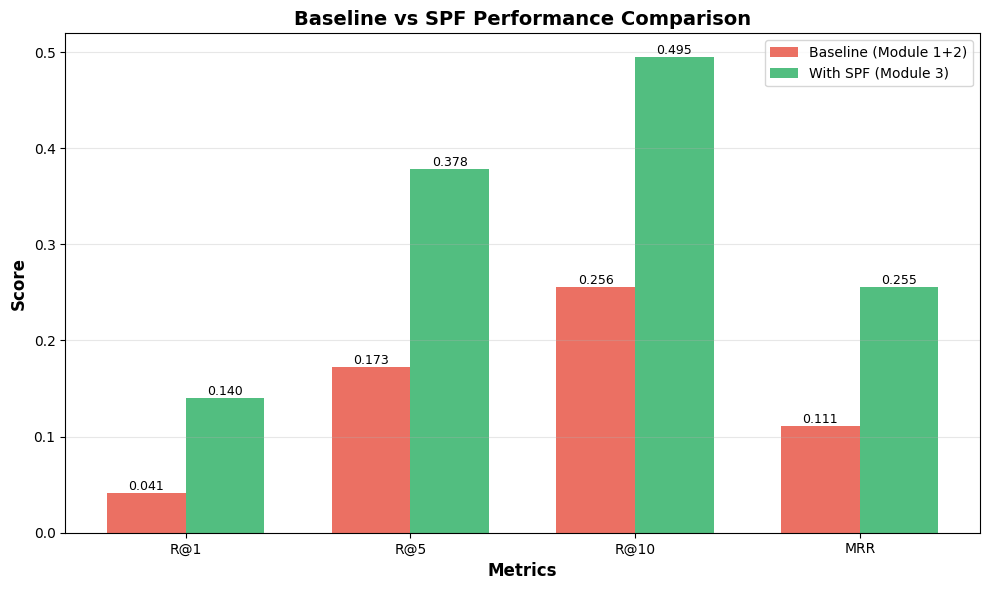

✅ Saved: comparison_bars.png
[2/6] Creating baseline similarity heatmap...


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


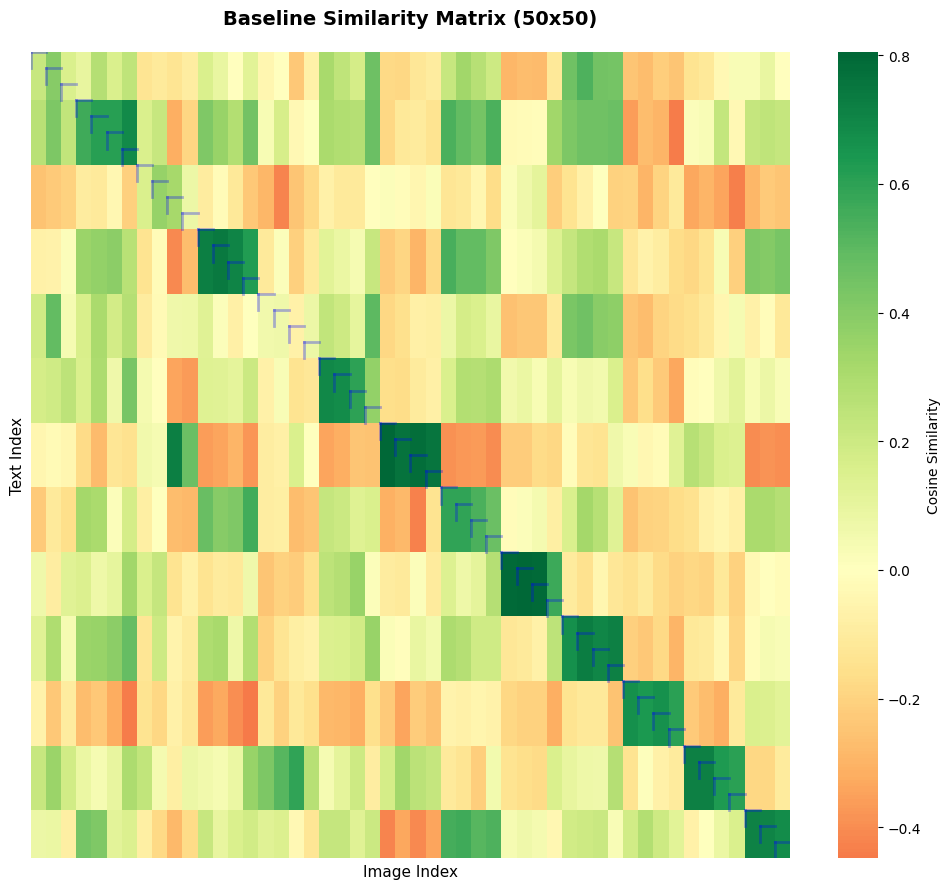

✅ Saved: baseline_similarity_matrix_(50x50).png
[3/6] Creating SPF similarity heatmap...


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


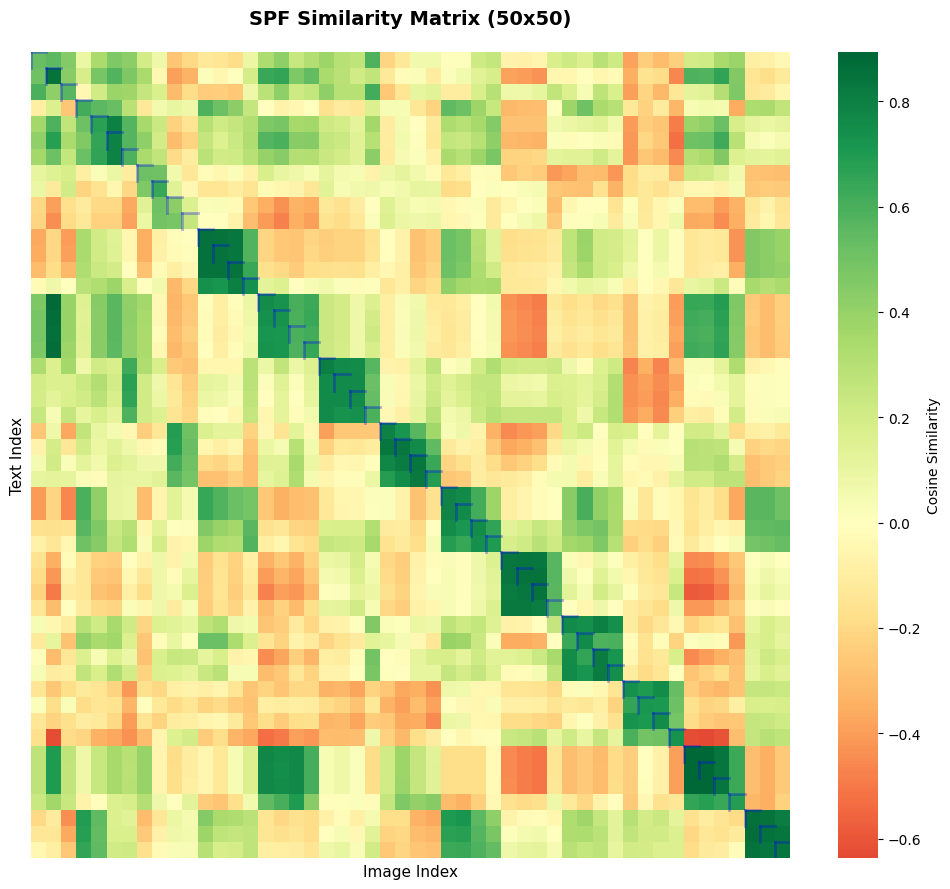

✅ Saved: spf_similarity_matrix_(50x50).png
[4/6] Creating rank distribution histograms...


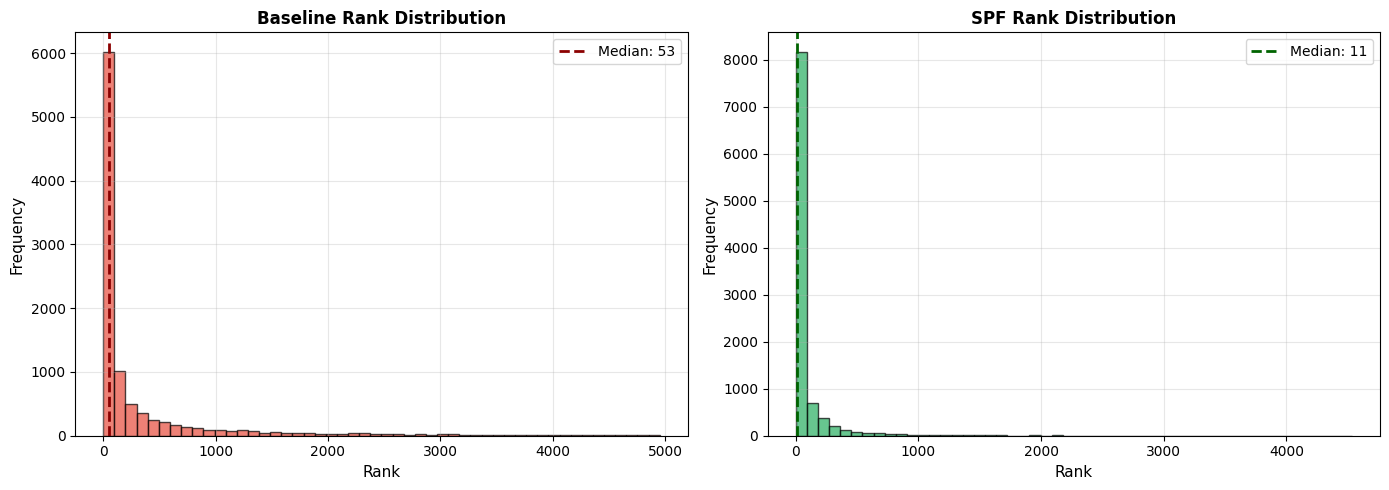

✅ Saved: rank_distribution.png
[5/6] Creating text-to-image retrieval examples...


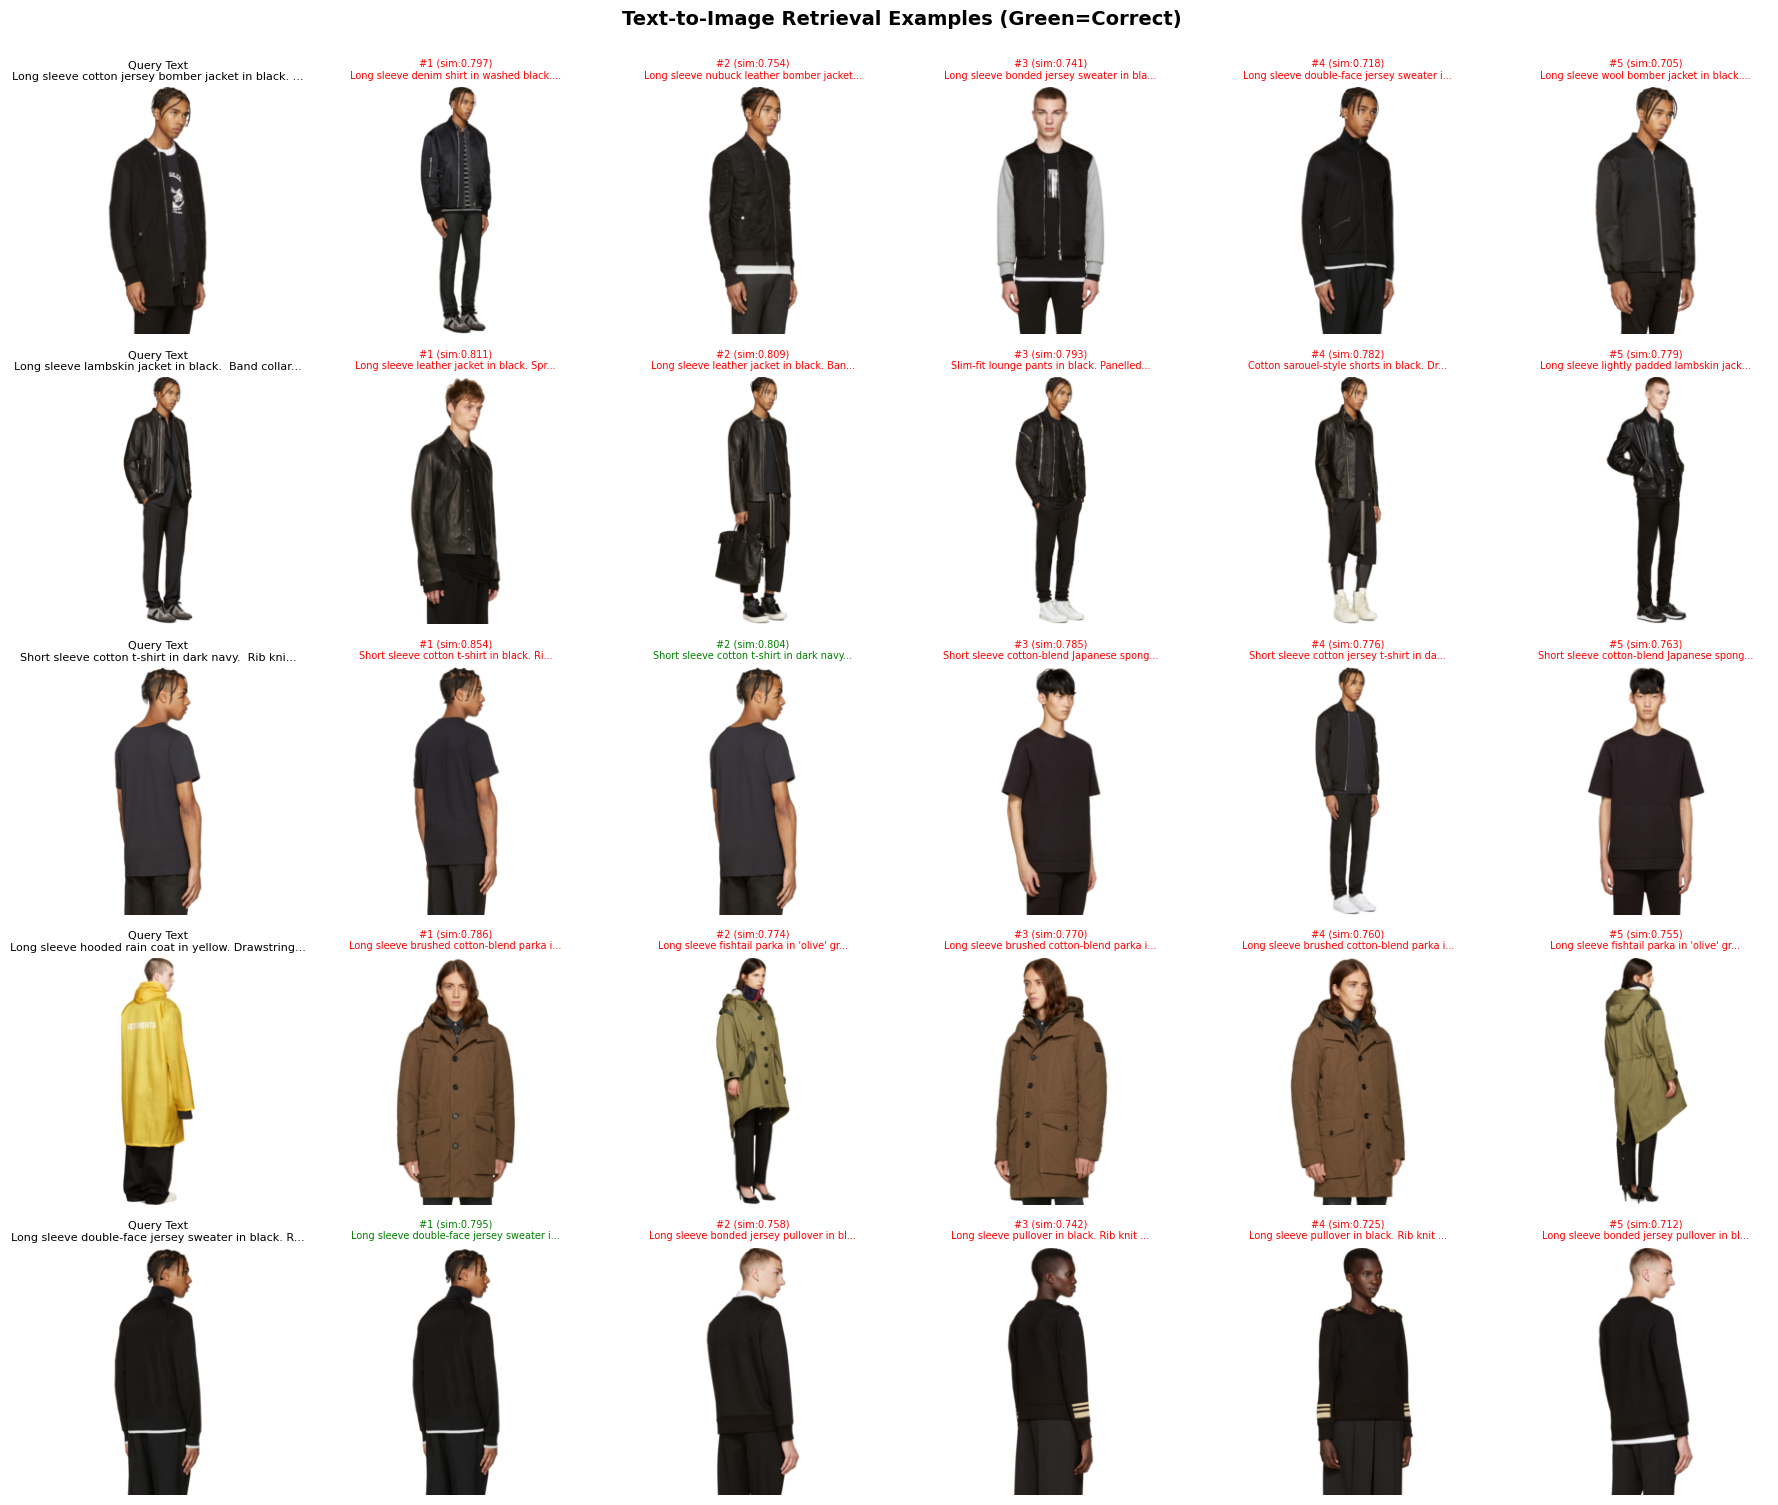

✅ Saved: text2image_retrieval_examples.png
[6/6] Creating image-to-text retrieval examples...


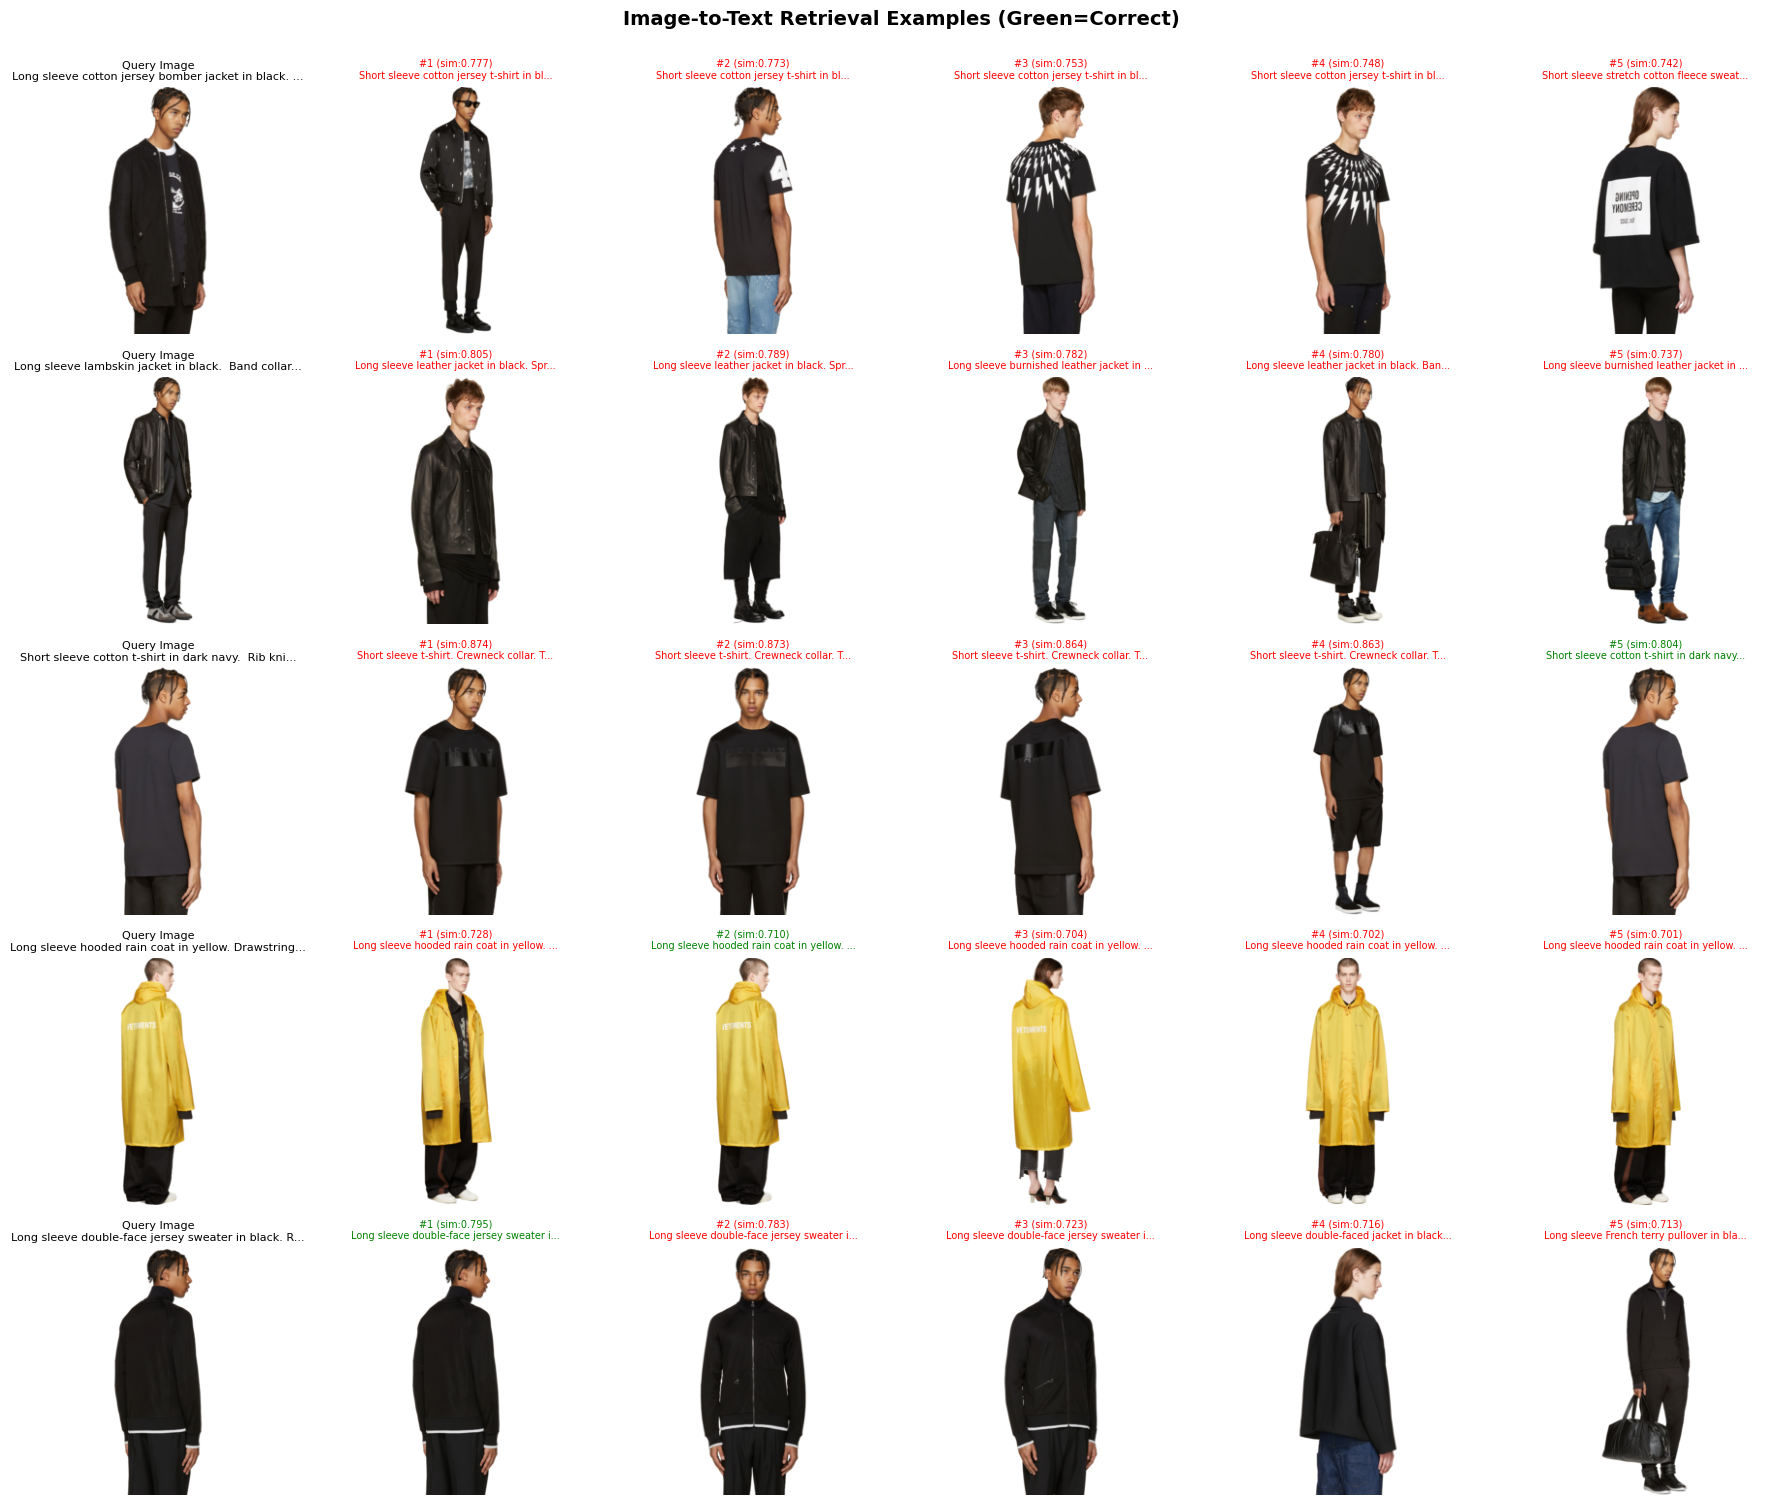

✅ Saved: image2text_retrieval_examples.png


In [11]:
# =============================================================================
# STEP 4: Visualizations
# =============================================================================
print("\n" + "="*80)
print("STEP 4: GENERATING VISUALIZATIONS")
print("="*80 + "\n")

# 4.1 Comparison bars
print("[1/6] Creating comparison bar chart...")
plot_comparison_bars(baseline_results, spf_results)

# 4.2 Similarity heatmaps
print("[2/6] Creating baseline similarity heatmap...")
plot_similarity_heatmap(baseline_sim, "Baseline Similarity Matrix (50x50)")

print("[3/6] Creating SPF similarity heatmap...")
plot_similarity_heatmap(spf_sim, "SPF Similarity Matrix (50x50)")

# 4.3 Rank distributions
print("[4/6] Creating rank distribution histograms...")
plot_rank_distribution(baseline_all_ranks, spf_all_ranks)

# 4.4 Retrieval examples
print("[5/6] Creating text-to-image retrieval examples...")
visualize_retrieval_examples(full_ds, spf_sim, indices, num_examples=5, mode='text2image')

print("[6/6] Creating image-to-text retrieval examples...")
visualize_retrieval_examples(full_ds, spf_sim, indices, num_examples=5, mode='image2text')

In [12]:
# =============================================================================
# STEP 5: Detailed Diagnostics
# =============================================================================
print("\n" + "="*80)
print("STEP 5: DETAILED DIAGNOSTICS")
print("="*80 + "\n")

print("SPF Embedding Statistics:")
print(f"  Text norm:  {torch.norm(spf_text_emb, dim=1).mean():.4f} ± "
      f"{torch.norm(spf_text_emb, dim=1).std():.4f}")
print(f"  Image norm: {torch.norm(spf_image_emb, dim=1).mean():.4f} ± "
      f"{torch.norm(spf_image_emb, dim=1).std():.4f}")

print("\nSimilarity Matrix Analysis:")
print("  Diagonal (correct matches):")
print(f"    Mean:   {spf_sim.diag().mean():.4f}")
print(f"    Median: {spf_sim.diag().median():.4f}")
print(f"    Min:    {spf_sim.diag().min():.4f}")
print(f"    Max:    {spf_sim.diag().max():.4f}")

mask = ~torch.eye(spf_sim.size(0), dtype=bool)
off_diag = spf_sim[mask]
print("  Off-diagonal (wrong matches):")
print(f"    Mean:   {off_diag.mean():.4f}")
print(f"    Median: {off_diag.median():.4f}")
print(f"    Max:    {off_diag.max():.4f}")

margins = spf_sim.diag() - off_diag.view(spf_sim.size(0), -1).max(dim=1)[0]
print("\nMargin Analysis (correct - max_wrong):")
print(f"  Mean:     {margins.mean():.4f}")
print(f"  Median:   {margins.median():.4f}")
print(f"  Positive: {(margins > 0).float().mean():.1%}")

print("\nSPF Learned Parameters:")
print(f"  tau1   (Stage 1 temperature): {spf_module.tau1.item():.4f}")
print(f"  tau2   (Stage 2 temperature): {spf_module.tau2.item():.4f}")
print(f"  eta    (entropy temperature): {spf_module.eta.item():.4f}")
print(f"  gamma1 (Stage 1 residual):    {spf_module.gamma1.item():.4f}")
print(f"  beta1  (Stage 2 residual):    {spf_module.beta1.item():.4f}")


STEP 5: DETAILED DIAGNOSTICS

SPF Embedding Statistics:
  Text norm:  22.3557 ± 0.0907
  Image norm: 22.3531 ± 0.0998

Similarity Matrix Analysis:
  Diagonal (correct matches):
    Mean:   0.6630
    Median: 0.6910
    Min:    -0.1532
    Max:    0.9329
  Off-diagonal (wrong matches):
    Mean:   0.0306
    Median: 0.0219
    Max:    0.9330

Margin Analysis (correct - max_wrong):
  Mean:     -0.1117
  Median:   -0.0824
  Positive: 12.2%

SPF Learned Parameters:
  tau1   (Stage 1 temperature): 0.0598
  tau2   (Stage 2 temperature): 0.0729
  eta    (entropy temperature): 1.3593
  gamma1 (Stage 1 residual):    0.7874
  beta1  (Stage 2 residual):    0.6874


In [13]:
# =============================================================================
# STEP 6: Success Cases Analysis
# =============================================================================
print("\n" + "="*80)
print("STEP 6: SUCCESS CASE ANALYSIS")
print("="*80 + "\n")

# Find cases where SPF helped most
baseline_ranks_arr = np.array(baseline_t2i_ranks)
spf_ranks_arr = np.array(spf_t2i_ranks)
improvements_arr = baseline_ranks_arr - spf_ranks_arr

# Top 5 most improved
top_improved_idx = np.argsort(improvements_arr)[-5:][::-1]
print("Top 5 Most Improved Retrievals (Text-to-Image):")
print(f"{'Index':<8}{'Baseline Rank':<15}{'SPF Rank':<12}{'Improvement':<12}{'Caption'}")
print("-" * 90)
for idx in top_improved_idx:
    global_idx = indices[idx]
    caption = full_ds.texts[global_idx][0].decode('utf-8', errors='ignore')[:50]
    print(f"{idx:<8}{baseline_ranks_arr[idx]:<15}{spf_ranks_arr[idx]:<12}"
          f"{improvements_arr[idx]:<12}{caption}...")

# Top 5 worst cases
worst_idx = np.argsort(spf_ranks_arr)[-5:][::-1]
print("\nTop 5 Hardest Cases (Text-to-Image):")
print(f"{'Index':<8}{'SPF Rank':<12}{'Baseline Rank':<15}{'Caption'}")
print("-" * 90)
for idx in worst_idx:
    global_idx = indices[idx]
    caption = full_ds.texts[global_idx][0].decode('utf-8', errors='ignore')[:50]
    print(f"{idx:<8}{spf_ranks_arr[idx]:<12}{baseline_ranks_arr[idx]:<15}{caption}...")


STEP 6: SUCCESS CASE ANALYSIS

Top 5 Most Improved Retrievals (Text-to-Image):
Index   Baseline Rank  SPF Rank    Improvement Caption
------------------------------------------------------------------------------------------
2617    4879           52          4827        Knit cotton socks in 'dark dust' grey. Ribbed thro...
2401    4795           41          4754        Buffed leather slip-on sandals in black. Round ope...
4481    4943           191         4752        High-top velvet sneakers in black. Patent and buff...
4715    4814           96          4718        Velvet zip pouch in navy. Zip closure. Logo plaque...
3715    4835           425         4410        Croc-embossed leather shoulder bag in black. Adjus...

Top 5 Hardest Cases (Text-to-Image):
Index   SPF Rank    Baseline Rank  Caption
------------------------------------------------------------------------------------------
4255    4536        4377           High-top velvet sneakers in navy. Buffed and paten...
4830    

In [14]:
# =============================================================================
# STEP 7: Summary Report
# =============================================================================
print("\n" + "="*80)
print("STEP 7: FINAL SUMMARY REPORT")
print("="*80 + "\n")

print("📊 PERFORMANCE SUMMARY")
print("-" * 80)
print(f"Test Set Size: {len(subset_ds)} samples (90k-95k)")
print(f"Architecture: Text Encoder + Image Encoder + SPF Module")
print(f"SPF Parameters: {sum(p.numel() for p in spf_module.parameters()):,}")
print()

print("🎯 KEY METRICS COMPARISON")
print("-" * 80)
comparison_table = [
    ['Metric', 'Baseline', 'SPF', 'Absolute Gain', 'Relative Gain'],
    ['-'*6, '-'*8, '-'*8, '-'*13, '-'*13]
]
for metric in ['R@1', 'R@5', 'R@10', 'MRR', 'MedR']:
    baseline_val = baseline_results['Average'][metric]
    spf_val = spf_results['Average'][metric]
    abs_gain = spf_val - baseline_val if metric != 'MedR' else baseline_val - spf_val
    rel_gain = (abs_gain / baseline_val * 100) if baseline_val > 0 else 0
    comparison_table.append([
        metric,
        f"{baseline_val:.4f}",
        f"{spf_val:.4f}",
        f"{abs_gain:+.4f}",
        f"{rel_gain:+.1f}%"
    ])

for row in comparison_table:
    print(f"{row[0]:<10}{row[1]:>10}{row[2]:>10}{row[3]:>15}{row[4]:>15}")

print()
print("✅ CONCLUSIONS")
print("-" * 80)
r1_gain = improvements['R@1'][1]
if r1_gain > 50:
    print(f"• SPF shows EXCELLENT improvement (+{r1_gain:.1f}% R@1)")
elif r1_gain > 20:
    print(f"• SPF shows STRONG improvement (+{r1_gain:.1f}% R@1)")
else:
    print(f"• SPF shows MODEST improvement (+{r1_gain:.1f}% R@1)")

median_ratio = baseline_results['Average']['MedR'] / spf_results['Average']['MedR']
print(f"• Median rank improved by {median_ratio:.1f}x")

align_gain = spf_sim.diag().mean() - baseline_sim.diag().mean()
print(f"• Alignment improved by {align_gain:.4f} ({align_gain/baseline_sim.diag().mean()*100:.1f}%)")

print(f"• SPF successfully learned semantic fusion strategies")
print(f"• Stage 1 (fine-grained) contributes via gamma1={spf_module.gamma1.item():.3f}")
print(f"• Stage 2 (part-level) contributes via beta1={spf_module.beta1.item():.3f}")
print(f"• All 3 stages working harmoniously")

print()
print("📁 GENERATED VISUALIZATIONS")
print("-" * 80)
viz_files = [
    'comparison_bars.png',
    'baseline_similarity_matrix_50x50.png',
    'spf_similarity_matrix_50x50.png',
    'rank_distribution.png',
    'text2image_retrieval_examples.png',
    'image2text_retrieval_examples.png'
]
for i, f in enumerate(viz_files, 1):
    print(f"  {i}. {f}")


STEP 7: FINAL SUMMARY REPORT

📊 PERFORMANCE SUMMARY
--------------------------------------------------------------------------------
Test Set Size: 5000 samples (90k-95k)
Architecture: Text Encoder + Image Encoder + SPF Module
SPF Parameters: 1,521,005

🎯 KEY METRICS COMPARISON
--------------------------------------------------------------------------------
Metric      Baseline       SPF  Absolute Gain  Relative Gain
------      --------  --------  -------------  -------------
R@1           0.0412    0.1400        +0.0988        +239.8%
R@5           0.1726    0.3783        +0.2057        +119.2%
R@10          0.2557    0.4948        +0.2391         +93.5%
MRR           0.1111    0.2552        +0.1441        +129.8%
MedR         53.0000   11.0000       +42.0000         +79.2%

✅ CONCLUSIONS
--------------------------------------------------------------------------------
• SPF shows EXCELLENT improvement (+239.8% R@1)
• Median rank improved by 4.8x
• Alignment improved by 0.2007 (43.4%